## Neural Collaborative Filtering

## Biweekly Report 7

## Jake Watts

In this section of the report, I implement a neural collaborative filtering architecture to create user recommendations using MovieLens data. Neural collaborative filtering can express matrix factorization as well as model non-linearities making it an improvement over applying an inner product over users and items for collaborative filtering.

MovieLens is a dataset that contains user rankings of movies on a scale from 0.5 to 5. Here I try to train a neural collaborative filtering model to give movie recommendations based on the users' rankings of other movies. To evaluate the model, I experiment with different embedding sizes to see what size leads to the best performance.
Sources:

https://arxiv.org/abs/1708.05031

https://keras.io/examples/structured_data/collaborative_filtering_movielens/

In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

## Data Exploration + Pre-Processing

Reading in MovieLens data and creating a pandas dataframe

In [2]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)

Here we can see the structure of the dataset. `userId` identifies the user giving the rating, `movieId` corresponds with the movie that the user is rating, `rating` is the users rating of the movie and `timestamp` corresponds with when the user rated the movie.

In [3]:
df.head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


Creating a list of unique users and movies and finding min and max ratings

In [4]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

The data contains 100,836 total observations with 610 unique users and 9724 unique movies for an average of 165 ratings per user. The ratings range from 0.5 to 5 and has an average of 3.5.

In [5]:
avg_rating = round(np.mean(df['rating']), 2)
observations = len(df)

print(
    "Total observations: {}, Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}, Average Rating {}".format(
        observations, num_users, num_movies, min_rating, max_rating, avg_rating
    ))

Total observations: 100836, Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0, Average Rating 3.5


Below we can see the distribution of ratings. Although the average rating is 3.5 the data appears to be higher at whole numbers compared to the neighboring numbers with half points. The most common rating is 4 and the least common is 0.5. The data is left-skewed.

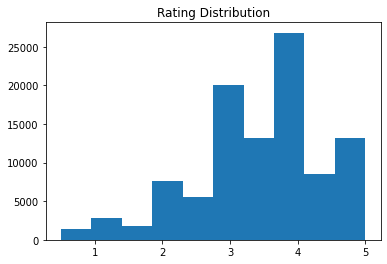

In [6]:
plt.hist(df['rating'])
plt.title('Rating Distribution')
plt.show()

Looking at the average rating grouped by users, we see that the data appears to follow a more normal distribution with a peak at 3.5. 

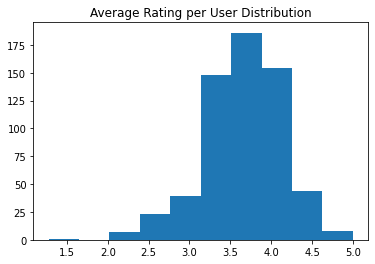

In [7]:
df2 = df[['user', 'rating']].groupby(by = "user").mean()
df2.head()

plt.hist(df2['rating'])
plt.title('Average Rating per User Distribution')
plt.show()

Normalizing ratings and creating training, validation, and testing datasets with `user` and `movie` as `x` and `rating` as `y`

In [8]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 80% of the data and validating on 10%.
train_indices = int(0.8 * df.shape[0])
test_indices = int(0.9 * df.shape[0])
x_train, x_val, x_test, y_train, y_val, y_test = (
    x[:train_indices],
    x[train_indices:test_indices],
    x[test_indices:],
    y[:train_indices],
    y[train_indices:test_indices],
    y[test_indices:]
)

## Model

Here I compile the model. The embedding size for both the users and the movies is set to 50. A match score is calculated between the user and the movie using a dot product. Then user and movie bias is added to the dot product and the sigmoid activation function scales the output from 0 to 1.

The model uses a binary cross-entropy loss with an Adam optimizer with a learning rate of 0.001.

In [9]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Training

Training the model for 12 epochs

In [10]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=12,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/12
1261/1261 [==============================] - 9s 6ms/step - loss: 0.6377 - val_loss: 0.6199
Epoch 2/12
1261/1261 [==============================] - 5s 4ms/step - loss: 0.6148 - val_loss: 0.6170
Epoch 3/12
1261/1261 [==============================] - 5s 4ms/step - loss: 0.6090 - val_loss: 0.6138
Epoch 4/12
1261/1261 [==============================] - 5s 4ms/step - loss: 0.6076 - val_loss: 0.6108
Epoch 5/12
1261/1261 [==============================] - 5s 4ms/step - loss: 0.6067 - val_loss: 0.6103
Epoch 6/12
1261/1261 [==============================] - 5s 4ms/step - loss: 0.6062 - val_loss: 0.6082
Epoch 7/12
1261/1261 [==============================] - 5s 4ms/step - loss: 0.6062 - val_loss: 0.6086
Epoch 8/12
1261/1261 [==============================] - 5s 4ms/step - loss: 0.6054 - val_loss: 0.6105
Epoch 9/12
1261/1261 [==============================] - 5s 4ms/step - loss: 0.6045 - val_loss: 0.6109
Epoch 10/12
1261/1261 [==============================] - 5s 4ms/step - loss: 0.604

After training for 12 epochs, we can see that the training and validation loss both decrease quickly for the first 5 epochs. However, the validation dataset appears to begin increasing while the training loss is still decreasing in the later epochs.

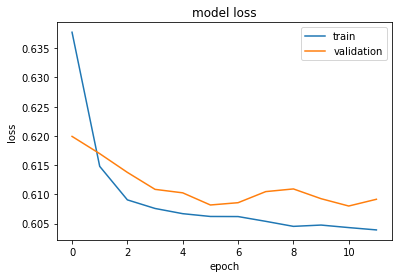

In [13]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper right")
plt.show()

## User Recommentations

After training the model, we can now look at recommendations for the users! The recommendations for the user below are mostly crime/thriller movies. The user does have a crime/thriller movie in their top-rated movies so that makes sense. However, it is hard to evaluate how interested the user would be in these movies unless we got feedback from the users about the recommendations.

In [14]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Showing recommendations for user: 165
Movies with high ratings from user
--------------------------------
Princess Bride, The (1987) : Action|Adventure|Comedy|Fantasy|Romance
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) : Action|Adventure
Indiana Jones and the Last Crusade (1989) : Action|Adventure
Ocean's Eleven (2001) : Crime|Thriller
Lord of the Rings: The Two Towers, The (2002) : Adventure|Fantasy
--------------------------------
Top 10 movie recommendations
--------------------------------
Bridge on the River Kwai, The (1957) : Adventure|Drama|War
Chinatown (1974) : Crime|Film-Noir|Mystery|Thriller
Shining, The (1980) : Horror
Evil Dead II (Dead by Dawn) (1987) : Action|Comedy|Fantasy|Horror
Cool Hand Luke (1967) : Drama
High Noon (1952) : Drama|Western
On the Waterfront (1954) : Crime|Drama
Fight Club (1999) : Action|Crime|Drama|Thriller
Double Indemnity (1944) : Crime|Drama|Film-Noir
Snatch (2000) : Comedy|Crime|Thriller


## Altering the Embedding Size

Here I wanted to experiment with changing the embedding size to see how it affects the model. The initial embedding size was 50 and here I train a model using an embedding size of 35. I chose to decrease the embedding size as the previous model showed signs of overfitting so I wanted to decrease the complexity of the embedding vector to see if it would improve the recommendations.

In [25]:
EMBEDDING_SIZE = 35


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


After 12 epochs of training, the model has a slightly lower final loss than the original model (.6058 vs .6092.). However, it is difficult to say if this difference is significant. The validation loss shows a similar pattern to the original model when the loss increases after 6 epochs. Although this time it is not as large of an increase.

In [26]:
history2 = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=12,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/12
1261/1261 [==============================] - 6s 4ms/step - loss: 0.6404 - val_loss: 0.6196
Epoch 2/12
1261/1261 [==============================] - 5s 4ms/step - loss: 0.6136 - val_loss: 0.6177
Epoch 3/12
1261/1261 [==============================] - 5s 4ms/step - loss: 0.6069 - val_loss: 0.6104
Epoch 4/12
1261/1261 [==============================] - 5s 4ms/step - loss: 0.6038 - val_loss: 0.6077
Epoch 5/12
1261/1261 [==============================] - 5s 4ms/step - loss: 0.6019 - val_loss: 0.6065
Epoch 6/12
1261/1261 [==============================] - 5s 4ms/step - loss: 0.6006 - val_loss: 0.6064
Epoch 7/12
1261/1261 [==============================] - 5s 4ms/step - loss: 0.6001 - val_loss: 0.6068
Epoch 8/12
1261/1261 [==============================] - 5s 4ms/step - loss: 0.5986 - val_loss: 0.6051
Epoch 9/12
1261/1261 [==============================] - 5s 4ms/step - loss: 0.5982 - val_loss: 0.6064
Epoch 10/12
1261/1261 [==============================] - 6s 5ms/step - loss: 0.597

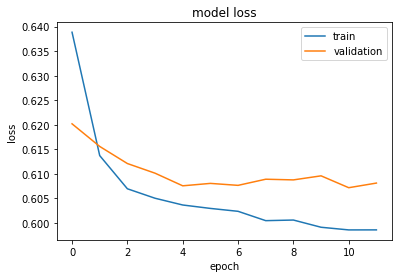

In [24]:
plt.plot(history2.history["loss"])
plt.plot(history2.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper right")
plt.show()

To try and get a sense of how different the new model is, I had the model give 10 recommendations to the same user as the previous model did. 5 of the recommendations were the same while five were different. This indicates that the model is moderately different than the previous model. It also looks like there is a little bit more variety in the genres recommended. I would think that is a good sign, however, it depends on what the user is looking for.

In [27]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Let us get a user and see the top recommendations.
user_id = 165
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Showing recommendations for user: 165
Movies with high ratings from user
--------------------------------
Princess Bride, The (1987) : Action|Adventure|Comedy|Fantasy|Romance
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) : Action|Adventure
Indiana Jones and the Last Crusade (1989) : Action|Adventure
Ocean's Eleven (2001) : Crime|Thriller
Lord of the Rings: The Two Towers, The (2002) : Adventure|Fantasy
--------------------------------
Top 10 movie recommendations
--------------------------------
Philadelphia Story, The (1940) : Comedy|Drama|Romance
Rear Window (1954) : Mystery|Thriller
Secrets & Lies (1996) : Drama
Bridge on the River Kwai, The (1957) : Adventure|Drama|War
Chinatown (1974) : Crime|Film-Noir|Mystery|Thriller
Shining, The (1980) : Horror
Evil Dead II (Dead by Dawn) (1987) : Action|Comedy|Fantasy|Horror
Cool Hand Luke (1967) : Drama
On the Waterfront (1954) : Crime|Drama
American History X (1998) : Crime|Drama


Finally, I want to create a model with an increased embedding size (65 instead of 50) to see how it affects the validation loss. I guess that it will be worse because decreasing the embedding size was helpful. However, I want to confirm if this is true since deep learning is not always intuitive.

In [28]:
EMBEDDING_SIZE = 65


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [29]:
history2 = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=12,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/12
1261/1261 [==============================] - 6s 4ms/step - loss: 0.6383 - val_loss: 0.6202
Epoch 2/12
1261/1261 [==============================] - 5s 4ms/step - loss: 0.6158 - val_loss: 0.6244
Epoch 3/12
1261/1261 [==============================] - 5s 4ms/step - loss: 0.6114 - val_loss: 0.6174
Epoch 4/12
1261/1261 [==============================] - 5s 4ms/step - loss: 0.6117 - val_loss: 0.6163
Epoch 5/12
1261/1261 [==============================] - 5s 4ms/step - loss: 0.6131 - val_loss: 0.6150
Epoch 6/12
1261/1261 [==============================] - 5s 4ms/step - loss: 0.6146 - val_loss: 0.6146
Epoch 7/12
1261/1261 [==============================] - 5s 4ms/step - loss: 0.6128 - val_loss: 0.6178
Epoch 8/12
1261/1261 [==============================] - 5s 4ms/step - loss: 0.6145 - val_loss: 0.6151
Epoch 9/12
1261/1261 [==============================] - 5s 4ms/step - loss: 0.6154 - val_loss: 0.6176
Epoch 10/12
1261/1261 [==============================] - 7s 6ms/step - loss: 0.612

After training for 12 epochs on the model with an increased embedding size, it appears that this model has a worse loss score than the previous models. Both the training and validations losses appear to increase in later epochs as well. This supports my hypothesis that having a large embedding size can lead to overfitting.

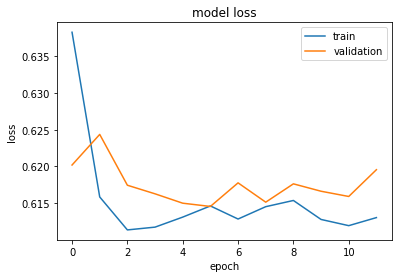

In [30]:
plt.plot(history2.history["loss"])
plt.plot(history2.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper right")
plt.show()

## Summary

Overall working to create movie recommendations based on MovieLens was a fun project. I sometimes use MovieLens to rate movies so it would be interesting to input my ratings and see what recommendations this model would give me.

In experimenting with embedding size, I learned that creating a shorter embedding vector may increase the quality of the movie recommendations after training. However, it can be more difficult to identify how well the model is doing when recommending movies that users have never seen. 

Evaluating the quality of recommendations is more difficult than evaluating other types of models because it is harder to look at the model's predictions on new data and tell if they are correct. In this way, recommendations are more of an art than a science. To evaluate new movie recommendations we would likely need to give these recommendations to a user and tweak the model based on user feedback.